In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_score,davies_bouldin_score
from sklearn.preprocessing import StandardScaler,normalize,RobustScaler,MinMaxScaler
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage
import collections
from sklearn.decomposition import PCA, KernelPCA,TruncatedSVD
%matplotlib inline 


MMS2_B = pd.read_csv('MMS2_B.csv',header = 0,names = ['times','Bx','By','Bz','date'],
                     dtype = {'Bz': np.float64},parse_dates=['date'])


MMS2_V = pd.read_csv('MMS2_V.csv',
                     header = 0,names = ['times','Vx','Vy','Vz','date'],
                     parse_dates=['date'])

MMS2_n = pd.read_csv('MMS2_n.csv',
                     header = 0,names = ['times','n','date'],
                     parse_dates=['date'])

MMS2_Tperp = pd.read_csv('MMS2_Tperp.csv',
                     header = 0,names = ['times','Tperp','date'],
                     parse_dates=['date'])

MMS2_Tpara = pd.read_csv('MMS2_Tpara.csv',
                     header = 0,names = ['times','Tpara','date'],
                         parse_dates=['date'])
all_vars = pd.read_csv('all_vars_outliers_removed.csv',header = 0,
                       usecols = ['times','Bx','By','Bz','Vx','Vy','Vz','n','Tpara','Tperp'])


# Data Preprocessing

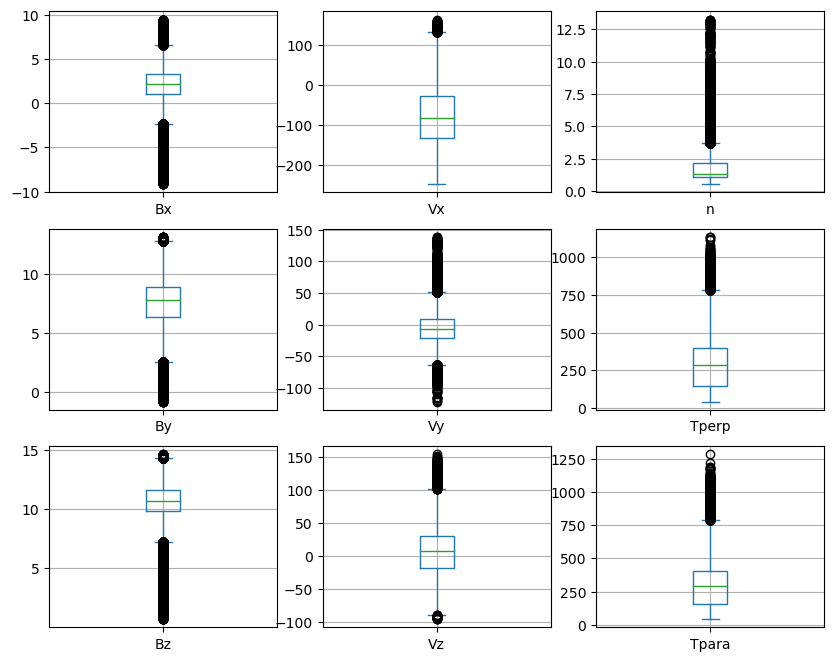

In [4]:
# look at box plots to see if there are any outliers

# define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,8))

# add DataFrames to subplots
MMS2_B['Bx'].plot(kind ='box',ax=axes[0,0],grid =True)
MMS2_B['By'].plot(kind ='box',ax=axes[1,0],grid =True)

MMS2_B['Bz'].plot(kind ='box',ax=axes[2,0],grid =True)

MMS2_V['Vx'].plot(kind ='box',ax=axes[0,1],grid =True)
MMS2_V['Vy'].plot(kind ='box',ax=axes[1,1],grid =True)
MMS2_V['Vz'].plot(kind ='box',ax=axes[2,1],grid =True)

MMS2_n['n'].plot(kind ='box',ax=axes[0,2],grid =True)
MMS2_Tperp['Tperp'].plot(kind ='box',ax=axes[1,2],grid =True)
MMS2_Tpara['Tpara'].plot(kind ='box',ax=axes[2,2],grid =True)

plt.show()

### Create a Dataframe with all variables.

### We have to address the different time cadences between B-field and the rest of the data

In [6]:
# # # Want a dataframe that contains all variables. 

# # # B-field has a different time cadence than the rest. 

closest_b_idx =[]
    
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx    



for t in times_v:
    closest_b_idx.append(find_nearest(times_b, t))

    
print(closest_b_idx) 
closest_b_idx1 = np.array(closest_b_idx)
#np.savetxt('closest_b_idx1.csv', closest_b_idx1, delimiter=',')

In [7]:
# create a dataframe that includes all variables. 

bx = np.array(MMS2_B['Bx'])
bx1 = bx[closest_b_idx]

by = np.array(MMS2_B['By'])
by1 = by[closest_b_idx]

bz = np.array(MMS2_B['Bz'])
bz1 = bz[closest_b_idx]

all_vars = pd.DataFrame({"times": times_v, "Bx": bx1,"By":by1,
    "Bz": bz1, "Vx":MMS2_V['Vx'],"Vy":MMS2_V['Vy'],"Vz":MMS2_V['Vz'],
                         "n":MMS2_n['n'],"Tpara":MMS2_Tpara['Tpara'],"Tperp":MMS2_Tperp['Tperp'],
                         "datetimes":MMS2_V['date']})

# all_vars = pd.DataFrame({"times": times_v, "Bx": bx1,"By":by1,
#     "Bz": bz1, "Vx":MMS2_V['Vx'],"Vy":MMS2_V['Vy'],"Vz":MMS2_V['Vz'],
#                          "n":MMS2_n['n'],"Tpara":MMS2_Tpara['Tpara'],"Tperp":MMS2_Tperp['Tperp']})

#all_vars.to_csv('MMS2_data_all.csv')

all_vars

In [7]:
# It looks like there may be some outliers. Define a function to detect them as we did in class:

# IQR code taken from class
def outliers_IQR(df,threshold):
    p0 = df.min()
    p100 = df.max()
    q1 = df.quantile(0.25)
    q2 = df.quantile(0.5)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    lc = q1 - threshold*iqr
    uc = q3+threshold*iqr
    outliers = df[(df < lc)| (df > uc)]
    outliers_idx = outliers.index
    return outliers, outliers_idx


# use a threshold of 3
threshold = 3

o_Bx,oidx_Bx = outliers_IQR(all_vars['Bx'],threshold)
o_By,oidx_By = outliers_IQR(all_vars['By'],threshold)
o_Bz,oidx_Bz = outliers_IQR(all_vars['Bz'],threshold)
o_Vx,oidx_Vx = outliers_IQR(all_vars['Vx'],threshold)
o_vy,oidx_Vy = outliers_IQR(all_vars['Vy'],threshold)
o_Vz,oidx_Vz = outliers_IQR(all_vars['Vz'],threshold)
o_n,oidx_n = outliers_IQR(all_vars['n'],5)
o_Tperp,oidx_Tperp = outliers_IQR(all_vars['Tperp'],threshold)
o_Tpara,oidx_Tpara = outliers_IQR(all_vars['Tpara'],threshold)

print('*******************************')
print('Outliers in Bx')
print('*******************************')
print(all_vars['Bx'][oidx_Bx])

print('*******************************')
print('Outliers in By')
print('*******************************')

print(all_vars['By'][oidx_By])

print('*******************************')
print('Outliers in Bz')
print('*******************************')

print(all_vars['Bz'][oidx_Bz])

print('*******************************')
print('Outliers in Vx')
print('*******************************')
print(all_vars['Vx'][oidx_Vx])

print('*******************************')
print('Outliers Vy')
print('*******************************')
print(all_vars['Vy'][oidx_Vy])


print('*******************************')
print('Outliers Vz')
print('*******************************')
print(all_vars['Vz'][oidx_Vz])



print('*******************************')
print('Outliers n')
print('*******************************')
print(all_vars['n'][oidx_n])


print('*******************************')
print('Outliers Tperp')
print('*******************************')
print(all_vars['Tperp'][oidx_Tperp])


print('*******************************')
print('Outliers Tpara')
print('*******************************')
print(all_vars['Tpara'][oidx_Tpara])



*******************************
Outliers in Bx
*******************************
54745    -5.861179
54746    -5.963643
54747    -6.081301
65440    -6.104286
65441    -6.600125
            ...   
116702   -7.071943
116703   -6.795309
116704   -6.425545
116705   -5.846818
116708   -5.799511
Name: Bx, Length: 88, dtype: float64
*******************************
Outliers in By
*******************************
Series([], Name: By, dtype: float64)
*******************************
Outliers in Bz
*******************************
49248    4.458973
49249    3.322506
49250    2.571084
49251    1.929480
49252    1.531167
           ...   
86521    3.153504
86522    3.459454
86523    3.972825
86524    4.293003
86525    4.501360
Name: Bz, Length: 117, dtype: float64
*******************************
Outliers in Vx
*******************************
Series([], Name: Vx, dtype: float64)
*******************************
Outliers Vy
*******************************
48630      97.506270
48633      94.087980
48634     

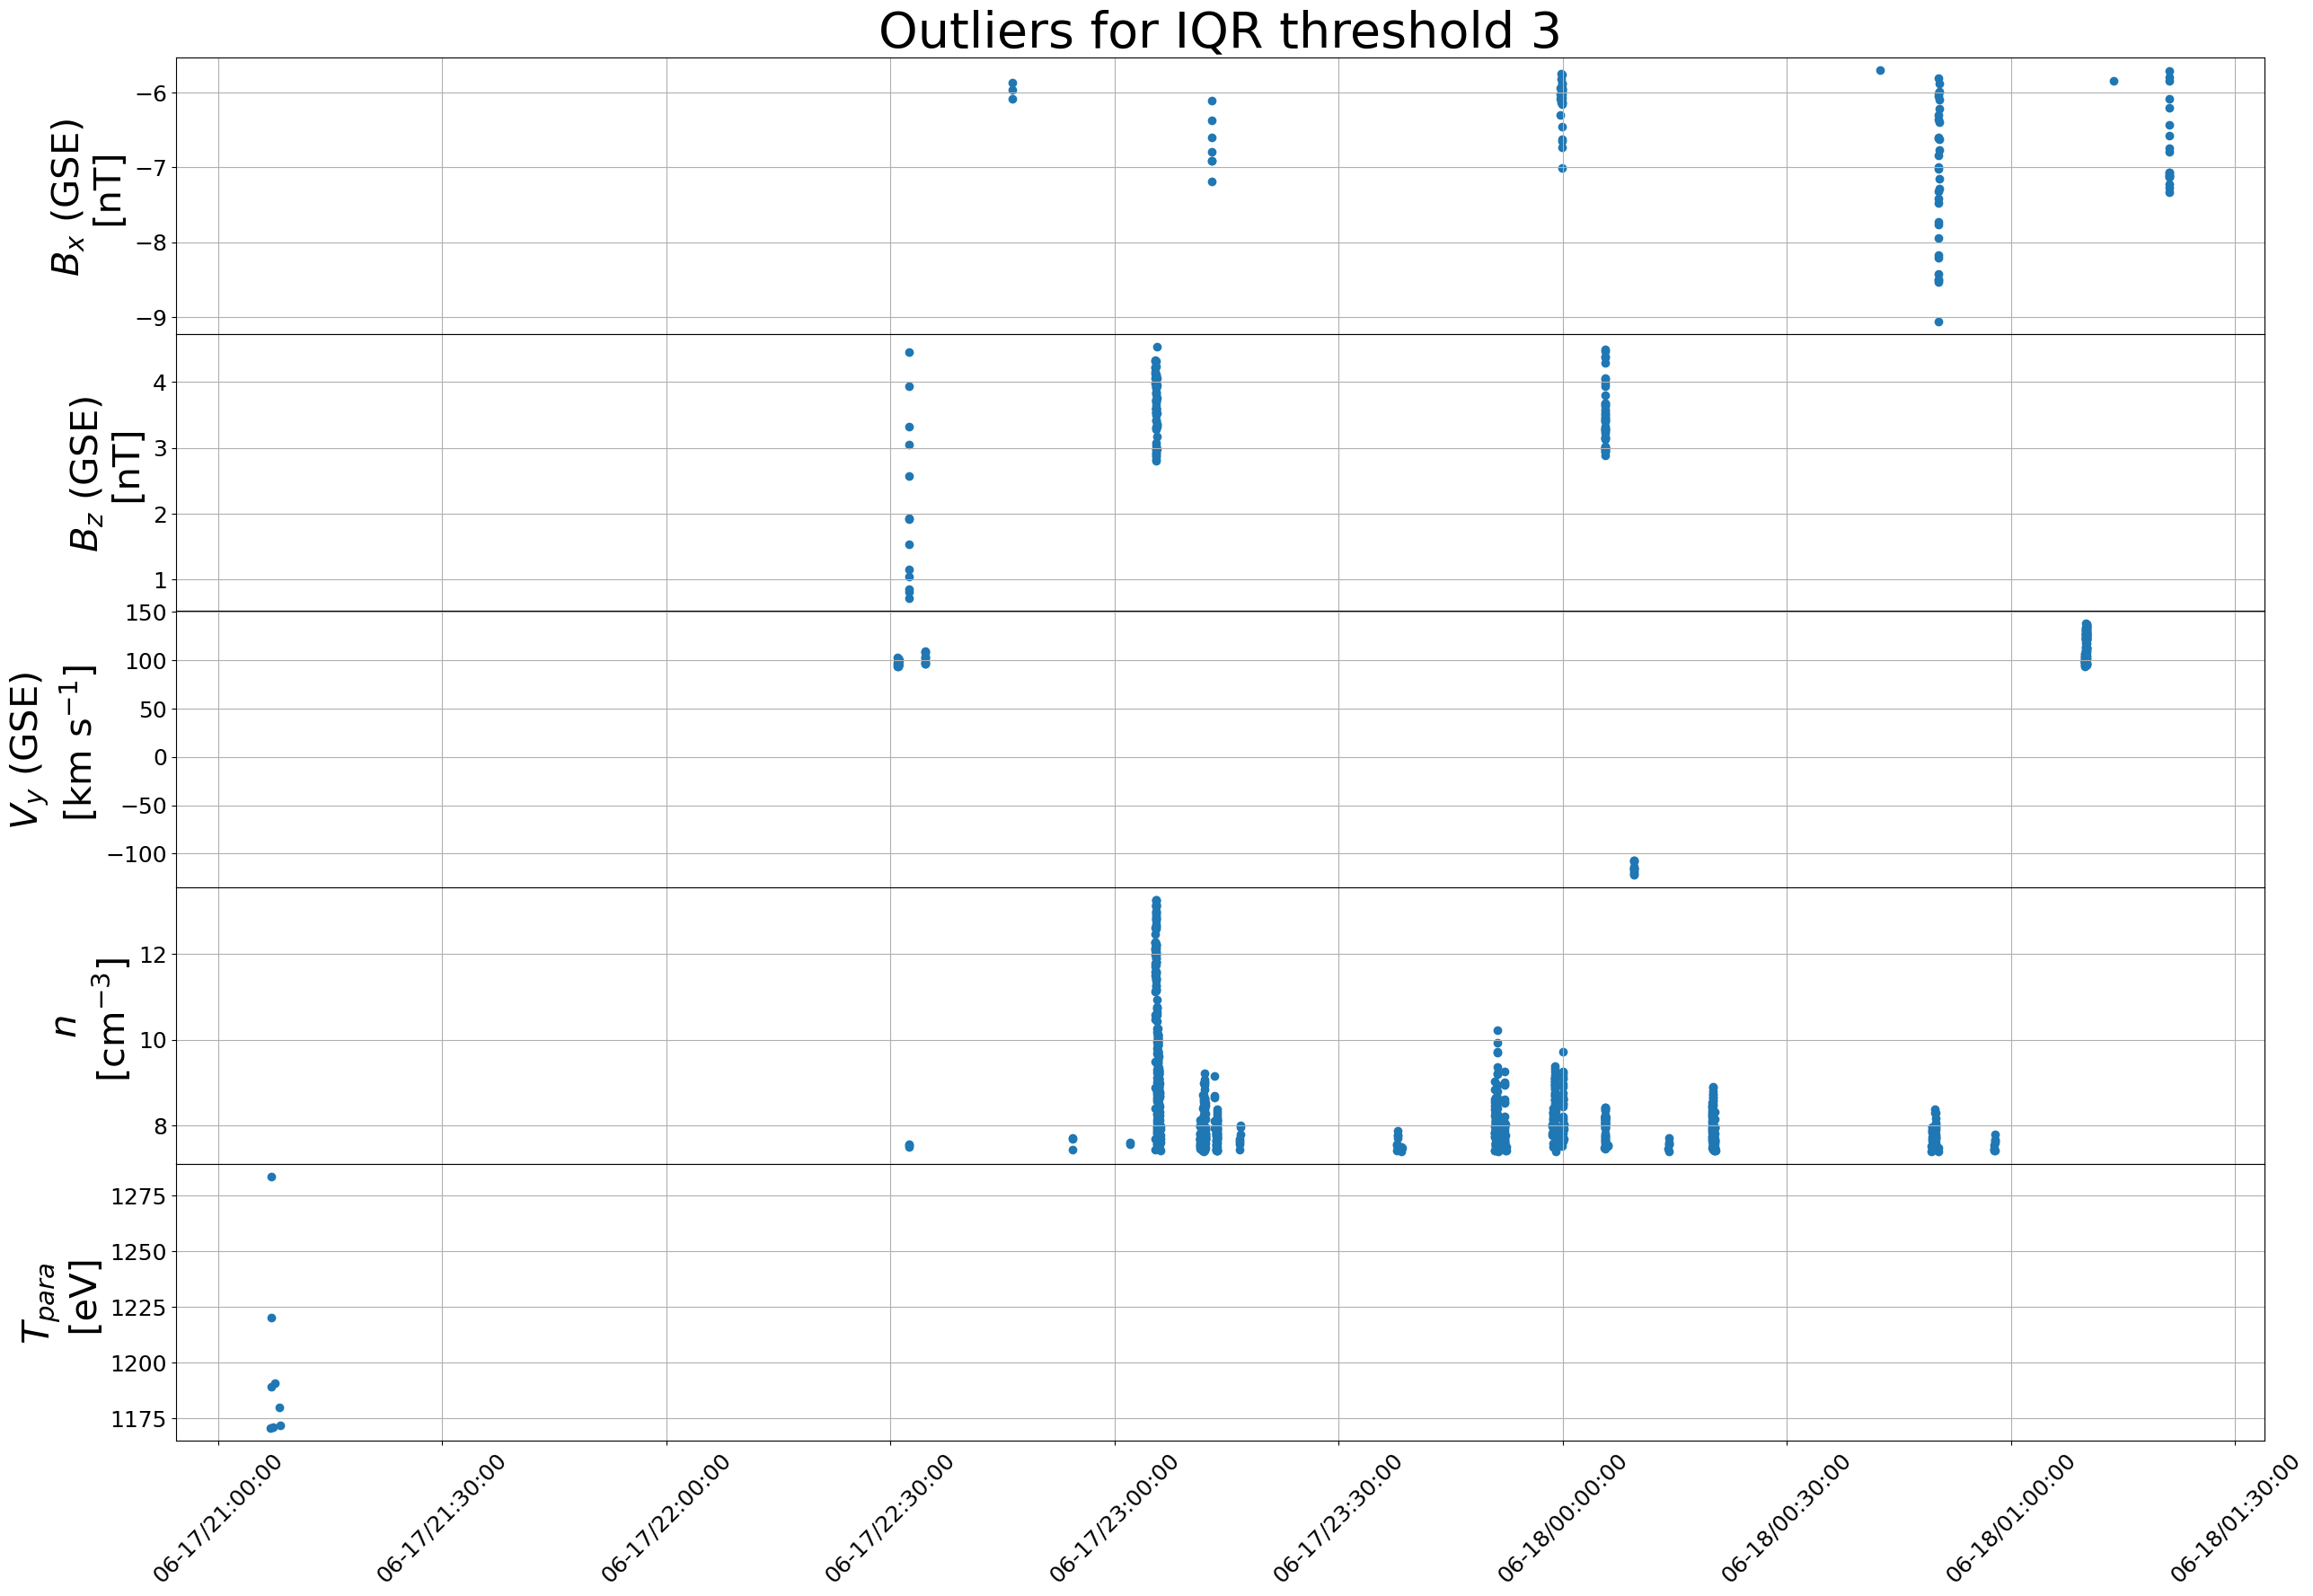

In [12]:
from matplotlib.dates import DateFormatter


fig = plt.figure(figsize=(30,20))
plt.rcParams.update({'font.size': 18})

dts = pd.to_datetime(all_vars['times'],unit='s')
#print(dts)
# Bx GSE
ax_Bx = fig.add_subplot(511)
ax_Bx.scatter(dts[oidx_Bx],all_vars['Bx'][oidx_Bx])
ax_Bx.grid('on')
# Set title and labels for axes
ax_Bx.set(ylabel = '$B_x$ (GSE) \n [nT]',
       title = "Outliers for IQR threshold {}".format(threshold))
ax_Bx.set_xticklabels([])
ax_Bx.title.set_fontsize(40)
ax_Bx.yaxis.label.set_fontsize(30)
# # Define the date format
date_form = DateFormatter("%m-%d/%H:%M:%S")
# ax_Bx.xaxis.set_major_formatter(date_form)
#ax_Bx.tick_params(axis='x', labelrotation=45)
ax_Bx.tick_params(axis='x', labelrotation=90)




# plt.title('f model: T= {}'.format(t)) or
# plt.title('f model: T= %d' % (t)




ax_Bz = fig.add_subplot(512,sharex=ax_Bx)
ax_Bz.scatter(dts[oidx_Bz],all_vars['Bz'][oidx_Bz])
ax_Bz.grid('on')
# Set title and labels for axes
ax_Bz.set(ylabel = '$B_z$ (GSE) \n [nT]')
ax_Bz.yaxis.label.set_fontsize(30)
ax_Bz.tick_params(axis='x', labelrotation=90)



ax_Vy = fig.add_subplot(513,sharex=ax_Bx)
ax_Vy.scatter(dts[oidx_Vy],all_vars['Vy'][oidx_Vy])
ax_Vy.grid('on')
# Set title and labels for axes
ax_Vy.set(ylabel= '$V_y$ (GSE) \n [km s$^{-1}$]')
ax_Vy.yaxis.label.set_fontsize(30)
ax_Vy.tick_params(axis='x', labelrotation=90)


ax_n = fig.add_subplot(514,sharex=ax_Bx)
ax_n.scatter(dts[oidx_n],all_vars['n'][oidx_n])
ax_n.grid('on')
# Set title and labels for axes
ax_n.set(ylabel= '$n$ \n [cm$^{-3}$]')
ax_n.yaxis.label.set_fontsize(30)
ax_n.tick_params(axis='x', labelrotation=90)

ax_Tpara = fig.add_subplot(515,sharex=ax_Bx)
ax_Tpara.scatter(dts[oidx_Tpara],all_vars['Tpara'][oidx_Tpara])
ax_Tpara.grid('on')
# Set title and labels for axes
ax_Tpara.set_ylabel('$T_{para}$ \n [eV]',fontsize=20)
ax_Tpara.xaxis.set_major_formatter(date_form)
ax_Tpara.tick_params(axis='x', labelrotation=45)
ax_Tpara.yaxis.label.set_fontsize(30)

plt.subplots_adjust(hspace = 0.0)
plt.show()

#fig.savefig('outliers')

In [10]:
fig = plt.figure(figsize=(30,10))

plt.scatter(all_vars['datetimes'],all_vars['Tpara'])
plt.grid()

In [11]:
#remove the most egregious outliers




Bx_out = np.array(all_vars['Bx'][oidx_Bx])
Bx_out_t = np.array(all_vars['times'][oidx_Bx])

n_out = np.array(all_vars['n'][oidx_n])
n_out_t = np.array(all_vars['times'][oidx_n])

Tpara_out = np.array(all_vars['Tpara'][oidx_Tpara])
Tpara_out_t = np.array(all_vars['times'][oidx_Tpara])

# for t in range(len(Bx_out)):
#     print(t,datetime.utcfromtimestamp(Bx_out_t[t]).strftime('%Y-%m-%d %H:%M:%S.%s'),Bx_out[t])

# for t in range(len(n_out)):
#     print(t,datetime.utcfromtimestamp(n_out_t[t]).strftime('%Y-%m-%d %H:%M:%S.%s'),n_out[t])

for t in range(len(Tpara_out)):
    print(t,datetime.utcfromtimestamp(Tpara_out_t[t]).strftime('%Y-%m-%d %H:%M:%S.%s'),Tpara_out[t])

    
    
# for t in range(len(Bx_out)):
#     print(t,datetime.utcfromtimestamp(Bx_out_t[t]).strftime('%Y-%m-%d %H:%M:%S.%s'),Bx_out[t])

# outliers to remove in Bx: 
    
# 36 2020-06-18 00:42:27.1592462547 -5.69573
# 69 2020-06-18 01:13:46.1592464426 -5.8378434


# outliers to remove in n

# 845 2020-06-18 00:20:09.1592461209 7.5366416
# 909 2020-06-18 00:49:59.1592462999 7.506693

indices_to_drop = [36,69,845,909]

all_vars1 = all_vars.drop(index=indices_to_drop)


